In [10]:
import csv
import ccxt
import json
import time
import random
import pyfolio as pf
import numpy as np
import pandas as pd
from datetime import datetime
from songline import Sendline
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [11]:
class EnvCSLinear(): 
    def __init__(self, 
                 data=None, 
                 initial_capital=300,
                 zone=[0,1],
                 minProvideSize=1, 
                 fee=0.02):
        # Data
        self.stock_price_history = data
        self.n_step = self.stock_price_history.shape[0]
        
        # Cap & fee
        self.initial_capital = initial_capital
        self.fee = fee
        
        # Linear params
        self.lower = zone[0]
        self.upper = zone[1]
        self.maxPos = self.initial_capital/((self.upper+self.lower)/2)
        self.minSize = minProvideSize
        
        # For plot visualize
        self.n_buy = None
        self.n_sell = None
        self.marker = None
        
        # LIFO 
        self.lifo_unit = None
        self.lifo_price = None
        self.cashflow = None

        self.cur_step = None
        self.position = None
        self.stock_price = None
        self.cash = None
        
        self.action_space = np.arange(3) #Action space <------ [0,1,2]
        self.state_space = 3 #State space <------ [pos, price, cash]
        
        self.reset()
        
    
    def plotLiearCurve(self):
        # For plot
        # plot linear
        x1 = np.arange(self.lower-self.lower*0.05, self.upper+self.upper*0.03, self.upper/100)
        y1 = np.array([self.linearFunc(i) for i in x1])
        # plot port value without cashflow
        x2 = np.arange(0, self.upper+self.upper*0.05, self.upper/100)
        y2 = np.array([self.valueWithoutCF(i) for i in x2])
        
        fig = plt.figure(figsize=(15,4))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        
        ax1.plot(x1, y1, 'orange')
        ax1.title.set_text('Linear Function')
        ax1.grid()
        ax1.set_ylabel('Position')
        ax1.set_xlabel('Price')
        
        ax2.plot(x2, y2, 'orange')
        ax2.title.set_text('Port Value Curve without Cashflow')
        ax2.grid()
        ax2.set_ylabel('Port Value')
        ax2.set_xlabel('Price')
        
        
    def reset(self):
        self.marker = []
        self.lifo_unit = []
        self.lifo_price = []
        self.cashflow = 0
        self.n_buy = 0
        self.n_sell = 0
        self.cur_step = 0
        self.position = 0
        self.stock_price = self.stock_price_history[self.cur_step]
        self.cash = self.initial_capital
        return self._get_obs()
        
    def step(self):
        prev_val = self.portvalue()
        
        self.cur_step += 1
        self.stock_price = self.stock_price_history[self.cur_step]
        self.trade()
        
        cur_val = self.portvalue()
        reward = cur_val - prev_val
        done = self.cur_step == self.n_step - 1
        info = {'cur_val': cur_val}
        
        return self._get_obs(), reward, done, info
    
    def _get_obs(self): 
        obs = np.empty(self.state_space)
        obs[0] = self.position
        obs[1] = self.stock_price
        obs[2] = self.cash
        return obs
      
    def portvalue(self):
        return self.position*self.stock_price + self.cash 
    
    def linearFunc(self, price):
        x1 = np.min([self.upper, price])
        x2 = np.max([self.lower, x1])
        m = self.maxPos/(self.lower-self.upper)
        pos = m*(x2-self.upper)
        return pos
    
    def valueWithoutCF(self, price):
        price = np.min([self.upper, price])
        rect = np.min([self.lower, price])
        y1 = self.linearFunc(price)
        value = 0.5*(self.maxPos+y1)*(price-rect)+self.maxPos*rect
        return value
    
    def trade(self):
        price = self.stock_price
        pos = self.position
        cash = self.cash
        
        adjPos = self.linearFunc(price) # must have position
        diff = adjPos-pos # diff position
        
        # sell = 0, hold = 1 buy = 2
        # Buy
        if diff>=self.minSize and self.cash>=int(diff)*price:
            #unit = int(diff)
            unit = diff
            self.cash -= unit*price
            self.position += unit
            self.buyinLIFO(unit, price)
            self.n_buy += 1
            self.marker.append(2)
            
        # Sell
        elif diff<=-self.minSize and self.position>=int(abs(diff)):
            #unit = int(abs(diff))
            unit = abs(diff)
            self.cash += unit*price
            self.position -= unit
            self.soldoutLIFO(unit, price)
            self.n_sell += 1
            self.marker.append(0)
        
        #Wait
        else:
            self.marker.append(1)
       
    # For calculate cashflow
    def buyinLIFO(self, buy_unit, buy_price):
        self.lifo_price.append(buy_price)
        self.lifo_unit.append(buy_unit)
      
    def soldoutLIFO(self, sold_unit, sold_price):
        sum_unit = 0
        list_unit = []
        list_price = []
          
        while  sum_unit < sold_unit:
            u = self.lifo_unit.pop()
            p = self.lifo_price.pop()
            sum_unit += u
            list_unit.append(u)
            list_price.append(p)
    
        for u, p in zip(list_unit, list_price):
            if u>sold_unit:
                self.cashflow += sold_unit*(sold_price-p) #- (sold_unit*sold_price)*self.fee/100 # - fee
                self.lifo_unit.append(u-sold_unit)
                self.lifo_price.append(p)
            else:
                self.cashflow += u*(sold_price-p) #- (u*sold_price)*self.fee/100 # - fee
                sold_unit-=u


In [3]:
apiKey = '0CEGxdBVbnEcdyxjAJAxgAQByFBWXw6ZqXAVem1p'
apiSecret = 'qmgFDUVEKK7VAFO90pVKlNKhDf_0kMC2W0nv2FN4'

exchange = ccxt.ftx({'apiKey' : apiKey, 'secret' : apiSecret, 'enableRateLimit' : True})
exchange.headers = {'FTX-SUBACCOUNT': 'TestSub',}

In [4]:
''''15s': '15',
    '1m': '60',
    '5m': '300',
    '15m': '900',
    '1h': '3600',
    '4h': '14400',
    '1d': '86400','''

def OHLCV(symbol, tf, limit=None):
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=tf, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['datetime', 'open', 'high', 'low', 'close', 'volume'])
    df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
    return df

In [5]:
df = OHLCV('XRP/USD', '1h', limit=None)

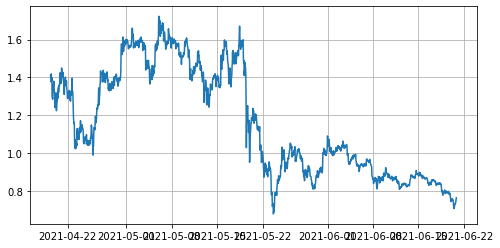

In [6]:
plt.figure(figsize=(8,4))
plt.plot(df['datetime'], df['close'])
plt.grid()

In [12]:
data = np.array([1,2,3])

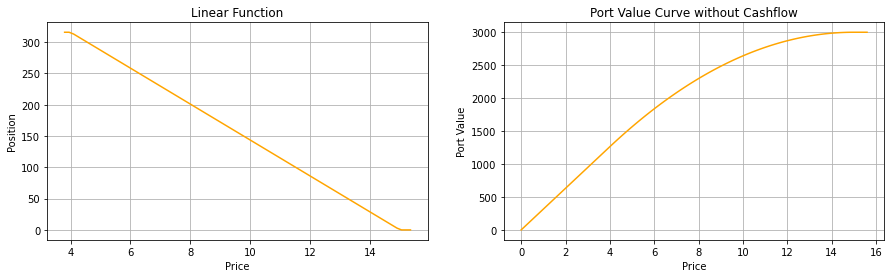

In [13]:
tb = 60
#data = df['close']
cs = EnvCSLinear(data, initial_capital=3000, zone=[4, 15], minProvideSize=1, fee=0) 
cs.plotLiearCurve()

========Backtesting Performance========
begin_portfolio_value: 3000.00
end_portfolio_value: 2743.93
buy: 1, sell: 0
cashflow: 0.000 = 0.000%
Len:1501, 1501.00 hrs. = 62.54 days


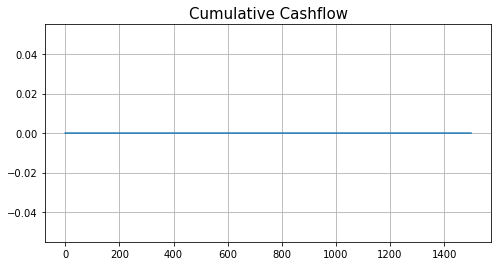

In [47]:
state = cs.reset()
cashflow = []
eqtc = []
i = 0

while True:
    
    next_state, reward, done, info = cs.step()
    cashflow.append(cs.cashflow)
    eqtc.append(cs.portvalue())
    #print(f'{i} price:{cs.stock_price}, pos from func:{cs.linearFunc(cs.stock_price):.3f}, position:{cs.position:.3f}, cash:{cs.cash:.3f}, cashflow:{cs.cashflow:.3f}')
    
    state = next_state
    i += 1
  
    if done:

        print(f'========Backtesting Performance========')
        print(f'begin_portfolio_value: {cs.initial_capital:.2f}')
        print(f'end_portfolio_value: {cs.portvalue():.2f}')
        print(f'buy: {cs.n_buy}, sell: {cs.n_sell}')
        print(f'cashflow: {cs.cashflow:.3f} = {cs.cashflow/cs.initial_capital*100:.3f}%')
        print(f'Len:{cs.n_step}, {cs.n_step*tb/60:.2f} hrs. = {(cs.n_step*tb/60)/24:.2f} days')
        print("=======================================")

        break
    
plt.figure(figsize=(8,4))
plt.plot(np.array(cashflow))
plt.grid()         
plt.title('Cumulative Cashflow', fontsize=15);            

In [33]:
cs.linearFunc(10)-cs.linearFunc(12)

57.416267942583715

In [13]:
bt_data = df.iloc[1:].reset_index(drop=True).set_index(['datetime'])
bt_data['equity curve'] = eqtc

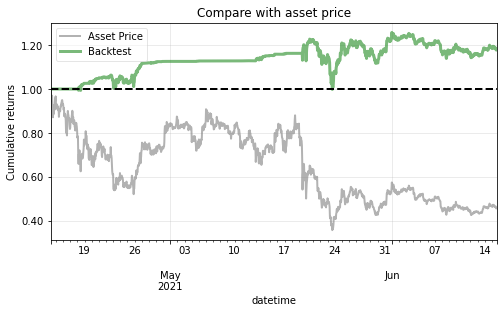

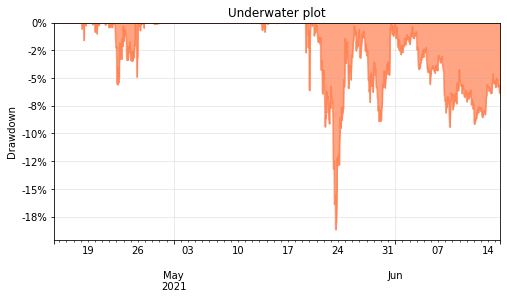

In [14]:
#PLot compare with benchmark
plt.figure(figsize=(8,4));
eqtc = bt_data['equity curve']
bt_data = bt_data.rename(columns = {'close': 'Asset Price'})

pf.plotting.plot_rolling_returns(eqtc.pct_change(), bt_data['Asset Price'].pct_change());
plt.grid(alpha=0.3)
plt.title('Compare with asset price');

plt.figure(figsize=(8,4));
pf.plot_drawdown_underwater(eqtc.pct_change());
plt.grid(alpha=0.3)

# compare zone

In [10]:
zone = [[0.1,1.2], [0.2,1.2], [0.1,1.4], [0.2,1.4], [0.1,1.6], [0.2,1.6], [0.1,1.8], [0.2,1.8]]

In [11]:
cashflow = [[] for i in zone]
count = 0

for i in (zone):
    cs = EnvCSLinear(data, initial_capital=300, zone=i, minProvideSize=1, fee=0) 

    state = cs.reset()
    
    while True:

        next_state, reward, done, info = cs.step()
        cashflow[count].append(cs.cashflow)

        state = next_state

        if done:
            break
            
    count += 1

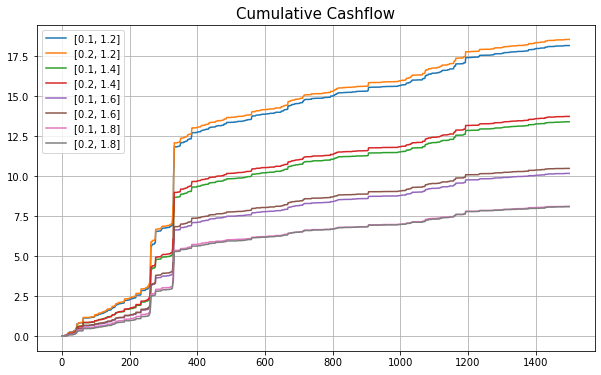

In [80]:
plt.figure(figsize=(10,6))
for i in range(len(zone)):
    plt.plot(cashflow[i])
plt.legend([str(i) for i in zone])
plt.grid()         
plt.title('Cumulative Cashflow', fontsize=15);